In [1]:
import glob
import math
import random
from typing import Callable, Union, Optional, List

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import pyplot as plt
import networkx as nx
from scipy.spatial import distance as distance_calculator
import torch
from torch import Tensor
from torch_geometric import nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv, global_max_pool, GATConv
import torch.nn.functional as F
from torch_geometric.typing import PairTensor, OptTensor
from torch_geometric.utils import scatter, to_networkx, add_self_loops
import seaborn as sn
from torch.nn import Sequential as Seq, Linear as Lin, Dropout, ReLU, BatchNorm1d as BN
from torch_geometric.nn.conv import MessagePassing
from torch_multi_head_attention import MultiHeadAttention
import torch_scatter
from torch_cluster import knn

In [2]:
random.seed(42)
column_names=['range','azimuth','doppler','snr','y','x','current_frame','seq']

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.zeros(len(features1), dtype=int), True)
max_frame = max(features1["current_frame"])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 1, dtype=int), True)
min_frame = min(features2["current_frame"])
shift = max_frame-min_frame+10
features2["current_frame"] += shift
max_frame = max(features2["current_frame"])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 2, dtype=int), True)
min_frame = min(features3["current_frame"])
shift = max_frame-min_frame+10
features3["current_frame"] += shift
max_frame = max(features3["current_frame"])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 3, dtype=int), True)
min_frame = min(features4["current_frame"])
shift = max_frame-min_frame+10
features4["current_frame"] += shift
max_frame = max(features4["current_frame"])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 4, dtype=int), True)
min_frame = min(features5["current_frame"])
shift = max_frame-min_frame+10
features5["current_frame"] += shift
max_frame = max(features5["current_frame"])

all_data = pd.concat([features1, features2, features3, features4, features5])
all_data.drop_duplicates(subset=['range','azimuth','doppler','snr','y','x','current_frame','Label'], inplace=True, ignore_index=True)
print("Number of data points: "+str(len(all_data)))

# group the data by frame numbers
all_data_grouped = all_data.groupby("current_frame")
print("Largest frame number: "+str(max_frame))
print("Total number of frames: "+str(len(all_data_grouped)))

Number of data points: 1242039
Largest frame number: 86242321.0
Total number of frames: 22126


In [3]:
data_array = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")

In [4]:
def data_split_sections(data_array, frames_per_feature):
    test_frac:float = 0.3
    train = []
    test = []
    frame_sum = 0
    for i in range(6):
        random.seed(42)
        frame_sum += frames_per_feature[i]
        test_length = int(np.round(frames_per_feature[i+1] * test_frac))
        test_start = random.randint(0,frames_per_feature[i+1] - test_length) + frame_sum
        print(test_start)
        test.extend(data_array[test_start:test_start+test_length])
        train.extend(data_array[frame_sum:test_start])
        train.extend(data_array[test_start+test_length:frame_sum+frames_per_feature[i+1]])
        print(np.unique([np.unique(t_frame["Label"].to_numpy()) for t_frame in test]))
        print(np.unique([np.unique(t_frame["Label"].to_numpy()) for t_frame in train]))
        print(str(len(train))+" + "+str(len(test))+" = "+str(len(train)+len(test)))
    return train, test

def random_split_keeping_graphs(data_array, frame_depth, test_frac):
    indexes = np.arange(len(data_array))
    random.seed(42)
    test_indexes = np.array(random.sample(range(len(data_array)-frame_depth-1), int(np.round(len(data_array) * (test_frac/(frame_depth*2))))))
    # print(test_indexes)
    for i in range(frame_depth):
        next_frame = test_indexes+(i+1)
        # print(next_frame)
        test_indexes = np.concatenate((test_indexes, next_frame))
    test_indexes = np.unique(test_indexes)
    train_indexes = np.setdiff1d(indexes, test_indexes)
    test = data_array[test_indexes]
    train = data_array[train_indexes]
    return train, test

In [5]:
train, test = random_split_keeping_graphs(data_array, 4, 0.15)
print(str(len(train))+" + "+str(len(test))+" = "+str(len(train)+len(test)))

17924 + 4202 = 22126


In [3]:
# data_array = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")
# random.seed(42)
# random.shuffle(data_array)
# train = data_array[:int(0.7 * len(data_array))]
# test = data_array[int(0.7 * len(data_array)):]
# val = data_array[int(0.85 * len(data_array)):]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def connect_frames(current_frame, previous_frame, k: int, start_index: int):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param previous_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of nearest neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :return: The values (distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph. 
            It also returns a boolean indicating whether the creation was successful or not.
    """
    edges = []
    adjacency_list = []
    previous_nodes = np.arange(len(previous_frame))
    for i, point in enumerate(current_frame):
        distances = distance_calculator.cdist([point], previous_frame, 'euclidean')[0]
        idx = distances.argsort()[::-1]
        distances = distances[idx]
        previous_nodes = previous_nodes[idx]
        if len(distances) < k:
            return [], [], False
        for j in range(k):
            edges.append(distances[j])
            adjacency_list.append((i+start_index, previous_nodes[j]+start_index+len(current_frame)))
    return edges, adjacency_list, True

def create_graph_list_with_overlap(frames:List[DataFrame], k = 3, frame_depth = 2):
    """
    Creates a list of Data objects that represents the graphs build from the input data. 
    The edges in the graph connects the frames to the previous frame by connecting each 
    points in a frame to it's nearest neighbour in the previous frame. 
    The nodes contain information about: doppler, snr, y and x. 
    The edges store information about the distance between the points (closer points have higher value).
    
    :param frames: input data grouped and sorted by the frame number
    :param k: the number of nearest neighbours to connect each points to
    :param frame_depth: the number of frames, one graph should contain
    :return: a list of Data objects, containing information about the created graphs
    """
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = [rf[['doppler','snr','y','x']] for rf in relevant_frames]
        time_distance = relevant_frames[-1].iloc[0, 6] - relevant_frames[0].iloc[0, 6]
        if time_distance > frame_depth * 2:
            continue
        point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        for depth in range(frame_depth):
            pairwise_edges, pairwise_adjacency_list, success = \
                connect_frames(point_data_array[frame_depth-depth][:,2:], point_data_array[frame_depth-depth-1][:,2:], k, start_index)
            if not success:
                break
            start_index += len(relevant_frames[frame_depth-depth])
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[frame_depth-depth])
        if not success:
                continue
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        
        graphs.append(Data(x=torch.tensor(np.array(nodes), dtype=torch.float, device=device), 
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float, device=device),
                    y=torch.tensor(label, dtype=torch.int64, device=device)))
    return graphs

In [8]:
sorted_train_data = sorted(train,key=lambda x:x["current_frame"].max(axis=0))
train_frame_graphs = create_graph_list_with_overlap(sorted_train_data, k=5, frame_depth=4)
# torch.save(train_frame_graphs, "data/train_frame_graphs_k3_with_frame_num_separate_graphs.pt")
print(len(train_frame_graphs))

8129


In [9]:
sorted_test_data = sorted(test,key=lambda x:x["current_frame"].max(axis=0))
test_frame_graphs = create_graph_list_with_overlap(sorted_test_data, k=5, frame_depth=4)
# torch.save(test_frame_graphs, "data/test_frame_graphs_k3_with_frame_num_separate_graphs.pt")
print(len(test_frame_graphs))

1351


In [16]:
# random.seed(42)
# random.shuffle(frame_graphs)
# train = frame_graphs[:int(0.7 * len(frame_graphs))]
# test = frame_graphs[int(0.7 * len(frame_graphs)):int(0.85 * len(frame_graphs))]
# val = frame_graphs[int(0.85 * len(frame_graphs)):]
random.seed(42)
random.shuffle(train_frame_graphs)
random.seed(42)
random.shuffle(test_frame_graphs)

train_dataloader = DataLoader(train_frame_graphs[:1000], batch_size=32, shuffle=True, num_workers = 0) 
test_dataloader = DataLoader(test_frame_graphs[:300], batch_size=32, shuffle=True, num_workers = 0) 
# val_dataloader = DataLoader(val, batch_size=32, shuffle=True, num_workers = 0) 

In [11]:
def MLP(channels):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)
            
class GeneralizedTemporalSelfAttentionDynamicEdgeConv(MessagePassing):
    def __init__(self, nn: Callable, 
                 attention_in_features: int,
                 k: int,
                 aggr: str = 'mean',
                 **kwargs):
        
        super(GeneralizedTemporalSelfAttentionDynamicEdgeConv,
              self).__init__(aggr=aggr, flow='source_to_target', **kwargs)

        self.nn = nn
        self.multihead_attn = MultiHeadAttention(attention_in_features, 8)
        self.k = k
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.multihead_attn)
        reset(self.nn)

    def forward(self, x, data) -> Tensor:
        return self.propagate(data.edge_index, x=x, edge_attr=data.edge_attr, size=None, batch=data.batch)

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr) -> Tensor:
        msg = torch.cat([x_j, x_i - x_j, torch.reshape(edge_attr, (len(edge_attr),1))], dim=-1)
        return self.nn(msg)

    def aggregate(self, inputs: Tensor, index: Tensor,
                  dim_size: Optional[int] = None) -> Tensor:
        original_shape = inputs.shape
        attention_input_shape = list([int(original_shape[0] / self.k)]) + list(original_shape)
        attention_input_shape[1] = self.k
        self_attention_input = inputs.reshape(attention_input_shape)
        attn_output = self.multihead_attn(self_attention_input, self_attention_input, self_attention_input)
        attn_output = attn_output.reshape(original_shape)
        # Apply attention mechanism
        return scatter(attn_output, index, dim=self.node_dim, dim_size=dim_size,
                       reduce=self.aggr)


In [12]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, graph_convolution_layers=2, k=3, aggr='mean'):
        super().__init__()
        self.graph_convolution_layers = graph_convolution_layers

        self.conv1 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2*4 + 1 , 64, 64, 64]),
                                                                     attention_in_features=64, 
                                                                     k=k, 
                                                                     aggr=aggr)
        
        self.conv2 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 64 + 1, 128]),
                                                                     attention_in_features=128,
                                                                     k=k, 
                                                                     aggr=aggr)

        if graph_convolution_layers == 1:
            self.lin1 = MLP([64, 1024])
        elif graph_convolution_layers == 2:
            self.lin1 = MLP([128 + 64, 1024])

        self.mlp = Seq(
            MLP([1024, 512]), Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        if self.graph_convolution_layers == 1:
            x1 = self.conv1(data.x, data)
            out = self.lin1(x1)
        elif self.graph_convolution_layers == 2:
            x1 = self.conv1(data.x, data)
            x2 = self.conv2(x1, data)
            out = self.lin1(torch.cat([x1, x2], dim=1))
        
        out = scatter(src=out, index=data.batch, dim=0, reduce='mean')
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

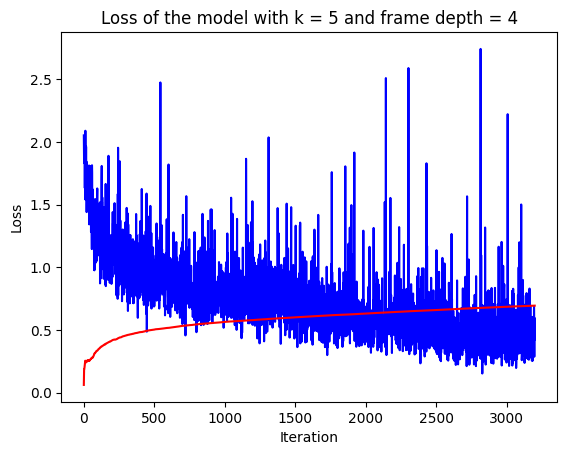

Training accuracy: 0.69507
Training loss: 0.51981825
Accuracy of the model with k = 5 and frame depth = 4: 0.6833


In [17]:
model = Net(5, graph_convolution_layers=1, k=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

model.train()
losses = []
correct = 0
count = 0
accuracies = []
for epoch in range(100):
    for train_batch in train_dataloader:
        train_batch = train_batch.to(device)
        optimizer.zero_grad()
        out = model(train_batch)
        pred = out.argmax(dim=1)
        correct += (pred == train_batch.y).sum()
        loss = F.nll_loss(out, train_batch.y)
        losses.append(loss.detach())
        loss.backward()
        optimizer.step()
        count += len(train_batch)
        acc = int(correct) / count
        accuracies.append(acc)
    scheduler.step()

losses = [tensor.cpu().numpy() for tensor in losses]

plt.plot(losses, c="blue")
plt.plot(accuracies, c="red")
plt.title(f"Loss of the model with k = 5 and frame depth = 4")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

print("Training accuracy: "+str(accuracies[-1]))
print("Training loss: "+str(losses[-1]))

model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for val_batch in test_dataloader:
    val_batch = val_batch.to(device)
    pred = model(val_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / 300
print(f'Accuracy of the model with k = 5 and frame depth = 4: {acc:.4f}')

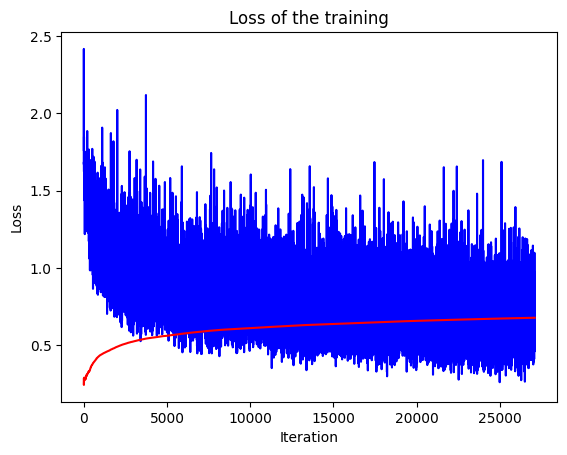

Accuracy: 0.6781596580406655
Loss: tensor(0.8247)


In [86]:
losses = [tensor.cpu() for tensor in losses]

plt.plot(losses, c="blue")
plt.plot(accuracies, c="red")
plt.title("Loss of the training")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

print("Accuracy: "+str(accuracies[-1]))
print("Loss: "+str(losses[-1]))

In [57]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloader:
    test_batch = test_batch.to(device)
    pred = model(test_batch).argmax(dim=1)
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    # print("Predicted: " + str(pred) + ", real: "+ str(test_batch.y))
    correct += (pred == test_batch.y).sum()
acc = int(correct) / 300
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6300


Text(0.5, 14.722222222222216, 'Predicated Label')

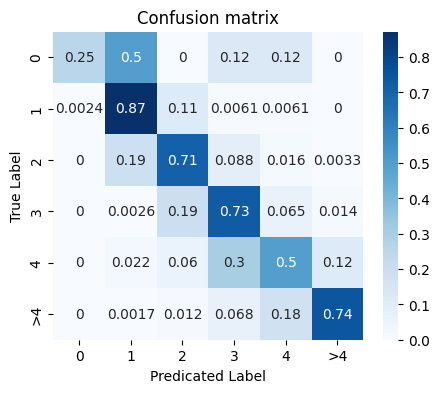

In [88]:
SHAPE_NAMES = [ 0,1,2,3,4,5]
SHAPE_LABELS = [ 0,1,2,3,4,">4"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
# print(cm)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

In [56]:
torch.save(model, "data/trained_model_k3_tesla_split_with_sections.pt")

In [ ]:
loaded_model = torch.load("data/trained_model_k3_tesla.pt")

In [ ]:
loaded_model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for val_batch in val_dataloader:
    val_batch = val_batch.to(device)
    pred = loaded_model(val_batch).argmax(dim=1)
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(val)
print(f'Accuracy: {acc:.4f}')

In [ ]:
SHAPE_NAMES = [0, 1,2,3,4,5]
SHAPE_LABELS = [ 0, 1,2,3,4,">4"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
# print(cm)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
# plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

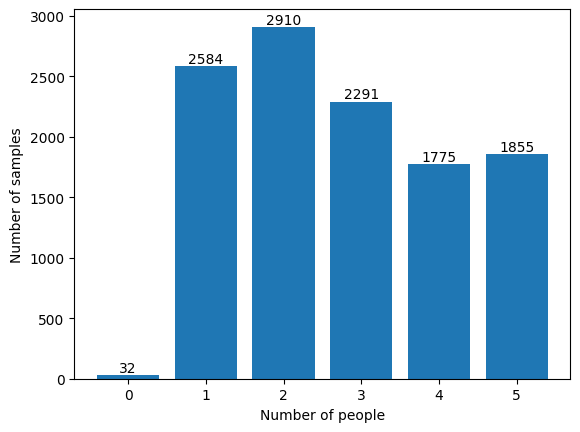

In [55]:
data_points = np.array([d.y.item() for d in train_frame_graphs])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
fives = len(np.where(data_points  == 5)[0])

labels = [0, 1,2,3,4,5]
sample_num = [zeros, ones, twos, threes, fours, fives]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()

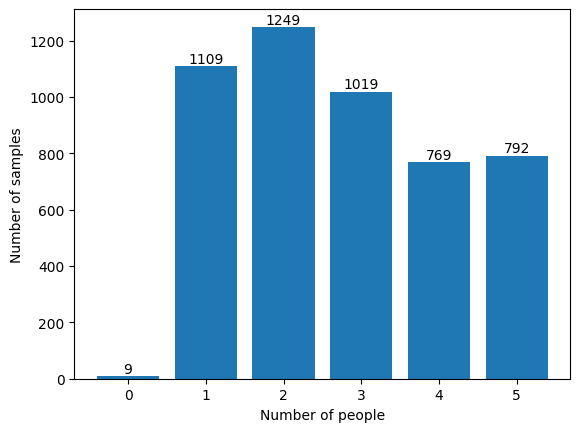

In [54]:
data_points = np.array([d.y.item() for d in test_frame_graphs])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
fives = len(np.where(data_points  == 5)[0])

labels = [0, 1,2,3,4,5]
sample_num = [zeros, ones, twos, threes, fours, fives]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()